> 此ipynb檔修改自：https://www.kaggle.com/code/ftaham/hr-analytics-predicting-job-change  
> 資料集來源： https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists/data


# Topic 1作業： HR Analytics: Job Change of Data Scientists (binary classfication)
* **1. 作業說明:**
    - 任務目標: 為了協助公司進行人力資源管理，請你幫公司預測哪些培訓者真正想在培訓後為公司工作，哪些會想尋找新工作(二元分類)。為了解釋給老闆你需要用可解釋性方法解釋你的預測結果。
    - 請填補程式中空缺(TODO:)部分:完成二元分類模型，及利用可解釋性方法解釋模型。最後請說明你於可解釋性方法中的發現。試著提高預測效果吧！
    - 當然，你也可以修改其他部分以提高預測效果。(不強制)
* **2. 學習目標:**
    - 資料前處理
    - 缺失值填補
    - 類別不平衡處理
    - 機器學習分類模型

* **資料集背景**
    - 一家活躍於大數據和數據科學領域的公司希望從通過公司舉辦的課程中成功畢業的人中招聘數據科學家。許多人報名參加了這些培訓。公司希望了解哪些候選人真正想在培訓後為公司工作，哪些是正在尋找新工作的。這有助於降低成本和時間，並提高培訓的質量，同時優化課程規劃和候選人分類。公司已經掌握了與候選人報名和注冊相關的人口統計、教育背景和工作經驗等信息。

    - 該數據集還旨在幫助人力資源研究，了解導致個人離開當前工作的因素。通過利用現有的資格證書、人口統計數據和工作經驗數據，您可以構建模型，預測候選人是否會尋找新工作，或者是否會留在公司工作，並解釋影響員工決策的因素。

    - 整個數據集分為訓練集和測試集。測試集中不包含目標標簽，但相關任務的測試目標值數據文件已提供。此外，還提供了對應測試集的enrollee_id的樣本提交文件，包含的列有：enrollee_id和target。-

    - **Note**：
        - The dataset is imbalanced.
        - Most features are categorical (Nominal, Ordinal, Binary), some with high cardinality.
        - Missing imputation can be a part of your pipeline as well.

- features
    - enrollee_id : Unique ID for candidate.
    - city: City code.
    - city_ development _index : Developement index of the city (scaled).
    - gender: Gender of candidate
    - relevent_experience: Relevant experience of candidate
    - enrolled_university: Type of University course enrolled if any
    - education_level: Education level of candidate
    - major_discipline :Education major discipline of candidate
    - experience: Candidate total experience in years
    - company_size: No of employees in current employer's company
    - company_type : Type of current employer
    - last_new_job: Difference in years between previous job and current job
    - training_hours: training hours completed

- label
    - target: 0 – Not looking for job change, 1 – Looking for a job change

**注意事項:**
1. 請將aug_train.csv放到"./data/"底下
2. 不要更動產生數值型缺失值的程式

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report,confusion_matrix

In [5]:
df=pd.read_csv("data/aug_train.csv")

原本數據集中沒有數值型缺失值，為了模擬有缺失值的情境隨機將部分資料數值替換為缺失值。

**(請勿修改此cell)**

In [6]:
np.random.seed(0)
# 挑出數值型特徵
num_feat= df.drop("target",axis=1).select_dtypes("number").columns
# 隨機將200筆資料數值替換為缺失值
for col in num_feat:
    idx=np.random.choice(df.index,size=200,replace=False)
    df.loc[idx,col]=np.nan

In [7]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949.0,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36.0,1.0
1,29725.0,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47.0,0.0
2,11561.0,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83.0,0.0
3,33241.0,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52.0,1.0
4,666.0,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8.0,0.0


In [8]:
# id特徵不重要，刪除
df.drop("enrollee_id",axis=1,inplace=True)

# **Data Exploration**

In [9]:
df.drop("target",axis=1).shape # we have 19158 example and 12 features

(19158, 12)

In [10]:
df.info() # most of the features have missing values and most of them are object kind

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  18958 non-null  float64
 2   gender                  14650 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     18772 non-null  object 
 5   education_level         18698 non-null  object 
 6   major_discipline        16345 non-null  object 
 7   experience              19093 non-null  object 
 8   company_size            13220 non-null  object 
 9   company_type            13018 non-null  object 
 10  last_new_job            18735 non-null  object 
 11  training_hours          18958 non-null  float64
 12  target                  19158 non-null  float64
dtypes: float64(3), object(10)
memory usage: 1.9+ MB


In [12]:
df.describe() # there are cleary varity in the numarical features range so we will need scaling
             # and they elso show a clear skewedness

,city_development_index,training_hours,target
count,18958.000000,18958.000000,19158.000000
mean,0.828898,65.381475,0.249348
std,0.123434,60.066121,0.432647
min,0.448000,1.000000,0.000000
25%,0.740000,23.000000,0.000000
50%,0.903000,47.000000,0.000000
75%,0.920000,88.000000,0.000000
max,0.949000,336.000000,1.000000


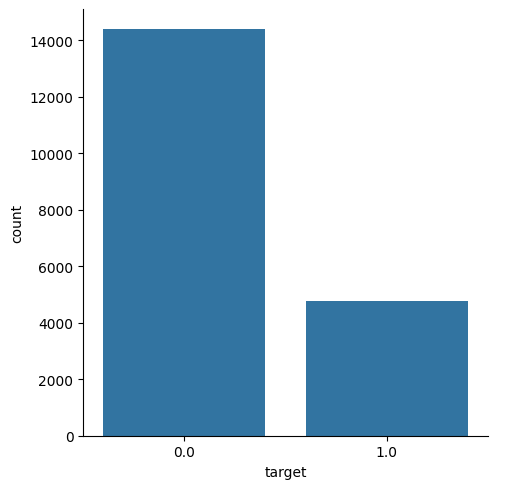

In [13]:
sns.catplot(x="target",data=df,kind="count")
plt.show() # clear imbalanced shown in the target

In [11]:
df.nunique() # The 'city' feature has 123 unique values, making it a high-cardinality categorical variable.
             # Using One-Hot Encoding would result in a very sparse matrix due to the large number of unique categories.
             # To avoid this issue and reduce dimensionality, we can use Frequency Encoding,
             # which replaces each city with the frequency of its occurrence in the dataset.(用該city出現的次數(數值型)來取代city(類別型))


,0
city,123
city_development_index,93
gender,3
relevent_experience,2
enrolled_university,3
education_level,5
major_discipline,6
experience,22
company_size,8
company_type,6


In [14]:
# performe frquent encoder (用該city出現的次數(數值型)來取代city(類別型))
city_freq=df["city"].value_counts(normalize=True)
df["city_freq"]=df["city"].map(city_freq)
df.drop("city",axis=1,inplace=True)

In [15]:
# 挑出數值型特徵
num_feat= df.drop("target",axis=1).select_dtypes("number").columns
# 挑出類別型特徵
cat_feat= df.drop("target",axis=1).select_dtypes("object").columns
print(num_feat)
print(cat_feat)

Index(['city_development_index', 'training_hours', 'city_freq'], dtype='object')
Index(['gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'company_size',
       'company_type', 'last_new_job'],
      dtype='object')


## **Categorical Analysis**

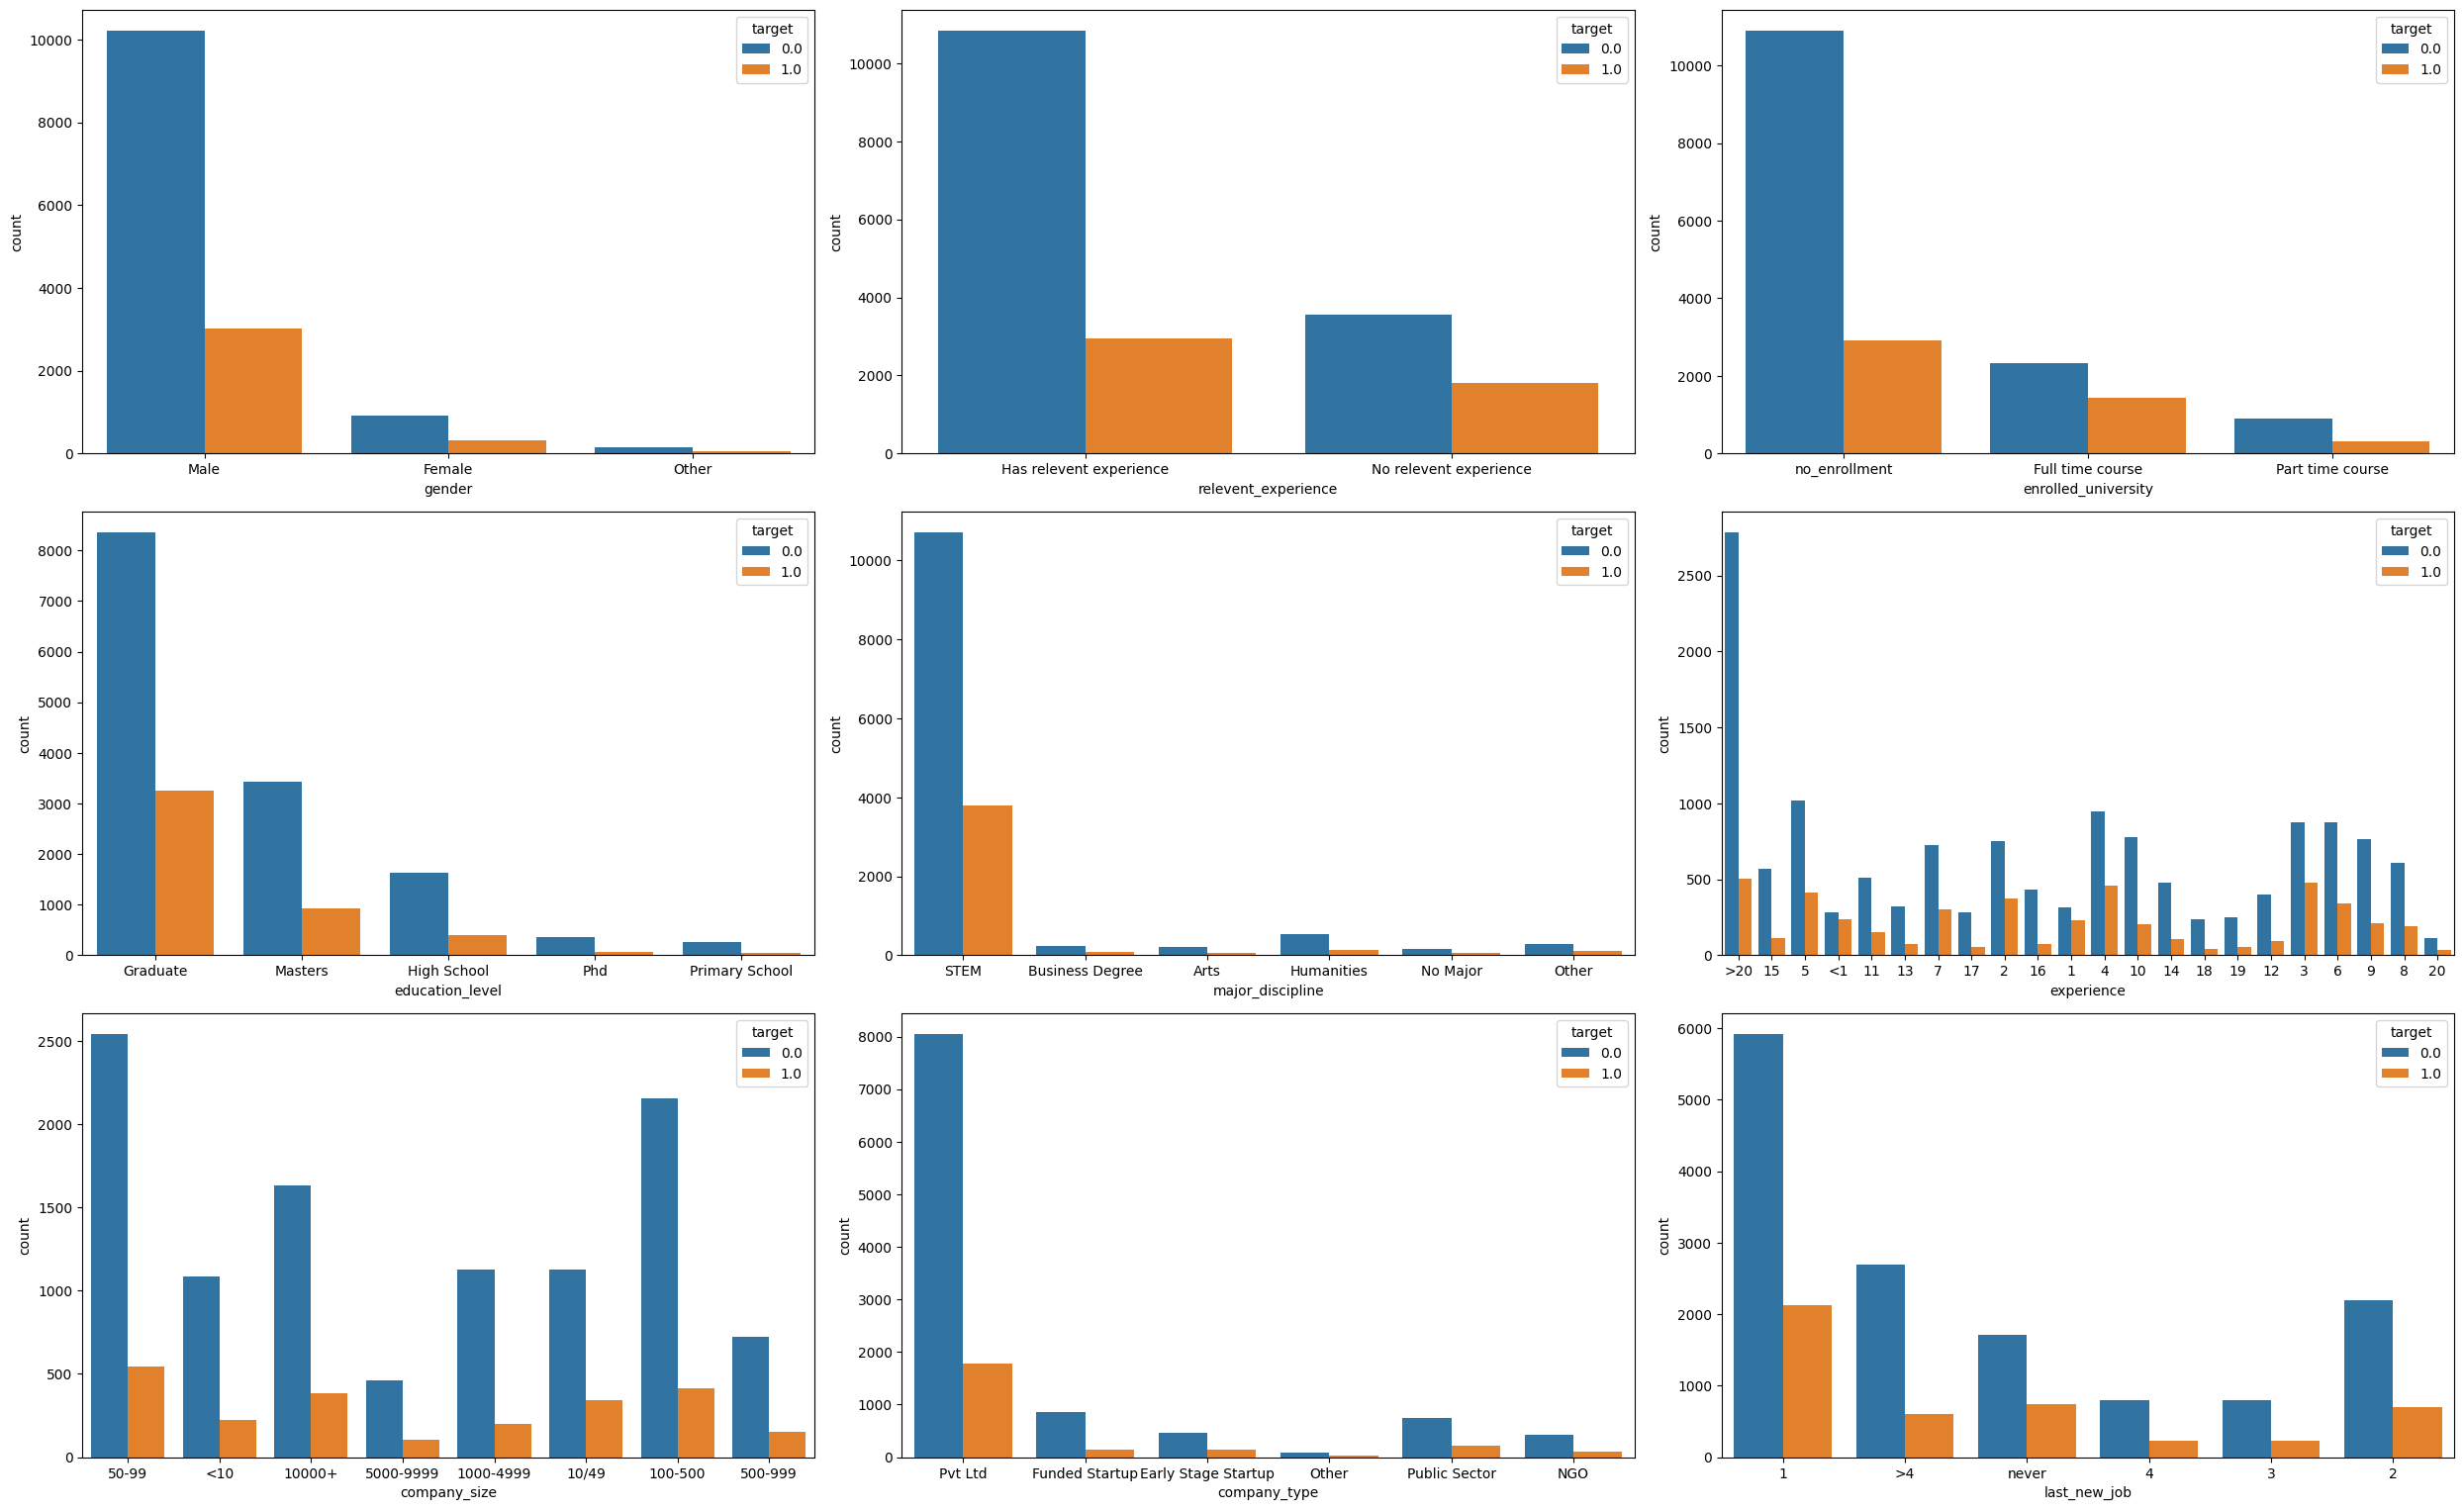

In [16]:
plt.figure(figsize=(25,20))
for i in range(len(cat_feat)):
    plt.subplot(4,3,i+1)
    sns.countplot(x=cat_feat[i],data=df.drop("target",axis=1),hue=df['target'])
plt.tight_layout()
plt.show()

## **Numarical Analysis**

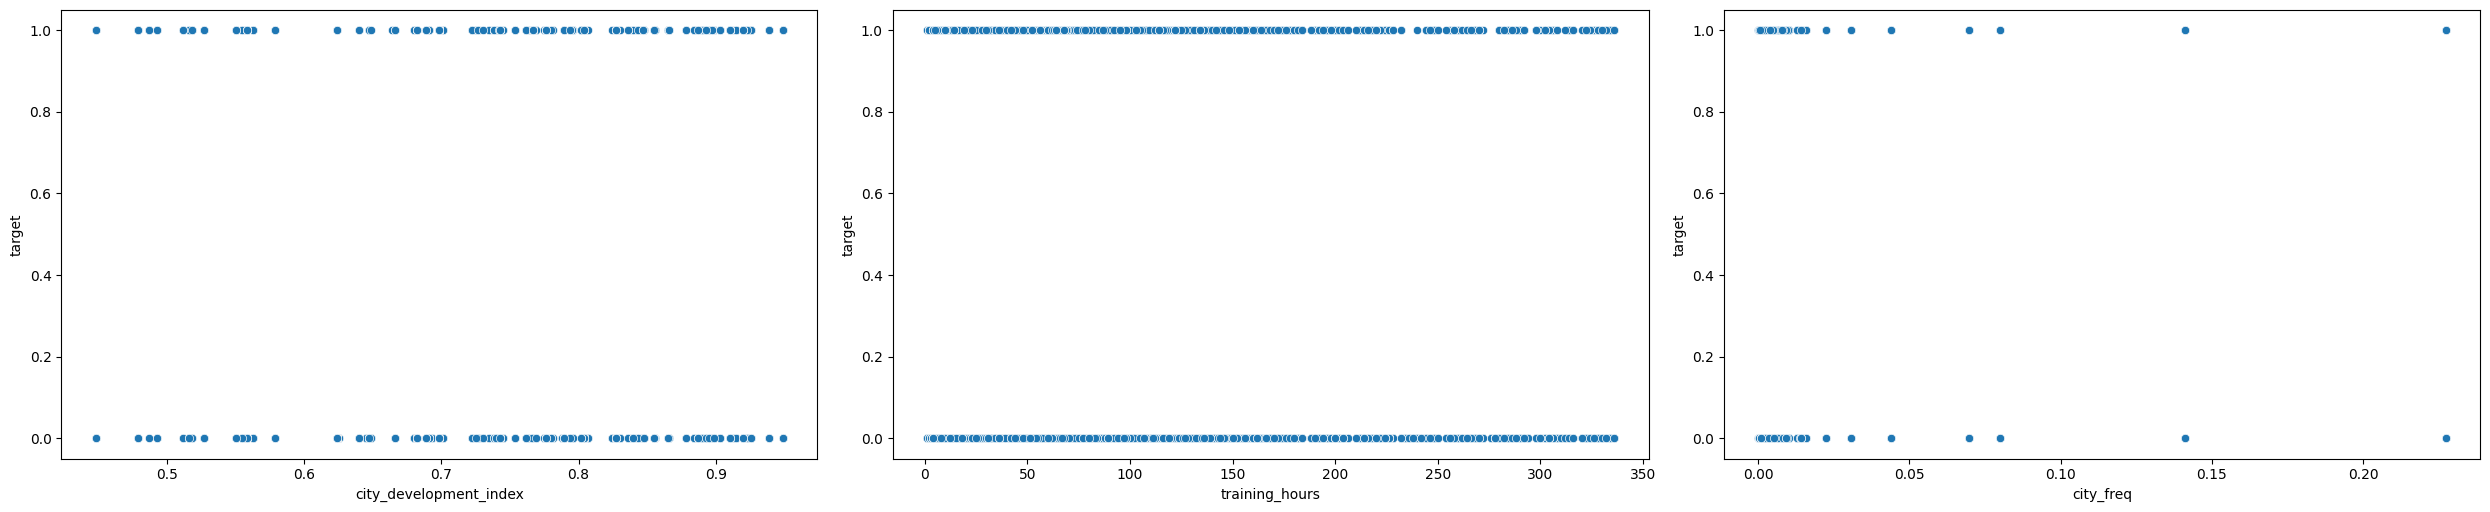

In [17]:
plt.figure(figsize=(25,20))
for i in range(len(num_feat)):
    plt.subplot(4,3,i+1)
    sns.scatterplot(x=num_feat[i],data=df.drop("target",axis=1),y=df['target'])
plt.tight_layout()
plt.show()

#Based on these scatter plots, it does seem that neither city_development_index nor training_hours has a strong linear relationship
#with the target variable. However, this does not necessarily mean they are not useful in prediction.

<!-- # **Stratified Split** -->

# **Data Preprocessing**

## 1. Missing value imputation

In [18]:
! pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 8.7 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29880 sha256=f5e463198636e45f10f93d74cb70f3b5c7c656706f519b579040ef2223efb4ab
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11330 sha256=c0aab97c626059685ab27d7c977c4e93e7961c41d9daa4b71ffff44553d37dc4
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [19]:
df.isnull().sum() # there are missing values

,0
city_development_index,200
gender,4508
relevent_experience,0
enrolled_university,386
education_level,460
major_discipline,2813
experience,65
company_size,5938
company_type,6140
last_new_job,423


In [20]:
# 填補類別型特徵
cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_feat] = cat_imputer.fit_transform(df[cat_feat])

In [21]:
from fancyimpute import SimpleFill
# 填補數值型特徵
########### TODO: 嘗試其他進階的填補方法(ex.MICE, KNN...) ##############
# num_imputer = SimpleFill(fill_method='mean')
num_imputer =
#########################################################
df[num_feat] = num_imputer.fit_transform(df[num_feat])

In [23]:
df.isnull().sum() # there are no missing values

,0
city_development_index,0
gender,0
relevent_experience,0
enrolled_university,0
education_level,0
major_discipline,0
experience,0
company_size,0
company_type,0
last_new_job,0


## 2. One-Hot Encoder

In [24]:
# 對類別型資料做one-hot encodding
df_one_hot = pd.get_dummies(df[cat_feat])

df_target = df["target"]
df = pd.concat([df[num_feat], df_one_hot], axis=1)
df = pd.concat([df, df_target], axis=1)

In [25]:
# one-hot encodding後的資料
df

,city_development_index,training_hours,city_freq,gender_Female,gender_Male,gender_Other,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,enrolled_university_Full time course,enrolled_university_Part time course,...,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never,target
0,0.920,36.0,0.227320,False,True,False,True,False,False,False,...,False,False,True,True,False,False,False,False,False,1.0
1,0.776,47.0,0.003549,False,True,False,False,True,False,False,...,False,False,True,False,False,False,False,True,False,0.0
2,0.624,83.0,0.141038,False,True,False,False,True,True,False,...,False,False,True,False,False,False,False,False,True,0.0
3,0.789,52.0,0.002819,False,True,False,False,True,False,False,...,False,False,True,False,False,False,False,False,True,1.0
4,0.767,8.0,0.006681,False,True,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,0.878,42.0,0.007882,False,True,False,False,True,False,False,...,False,False,True,True,False,False,False,False,False,1.0
19154,0.920,52.0,0.227320,False,True,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,1.0
19155,0.920,44.0,0.227320,False,True,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,0.0
19156,0.802,97.0,0.009135,False,True,False,True,False,False,False,...,False,False,True,False,True,False,False,False,False,0.0


## 3. normalize numerical features
對數值型特徵做normalization，使每個特徵的值被縮放到相同範圍。避免特徵值範圍不同影響模型訓練性能。

In [26]:
# Standard Scaler to normalize numerical features (zero mean, unit variance)
scaler = StandardScaler()
df[num_feat] = scaler.fit_transform(df[num_feat])

# **Stratified Split**
切分測試與訓練資料，並保持訓練與測試資料中各類別標籤比例相同

In [27]:
# first we split the data to train and test
# Stratified Split
x_train,x_test,y_train,y_test=train_test_split(df.drop("target",axis=1),df["target"],shuffle=True,stratify=df["target"],random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

print('All:', np.bincount(df["target"]) / float(len(df["target"])) * 100.0)
print('Training:', np.bincount(y_train) / float(len(y_train)) * 100.0)
print('Test:', np.bincount(y_test) / float(len(y_test)) * 100.0)

All: [75.06524689 24.93475311]
Training: [75.0626392 24.9373608]
Test: [75.07306889 24.92693111]


# **Handling class imbalance problem**

In [28]:
! pip install imblearn

## **Oversampling**

In [29]:
from collections import Counter

print('\nImbalanced dataset: ', Counter(y_train))


Imbalanced dataset:  Counter({0.0: 10785, 1.0: 3583})


In [30]:
from imblearn.over_sampling import SMOTE

########### TODO: 嘗試其他resampling方法 #############
# smote = SMOTE()
# x_train, y_train = smote.fit_resample(x_train, y_train)
resampling =
x_train, y_train =
############################

print('Size of resampling X:', x_train.shape)
print('Size of resampling y:', y_train.shape)
print('Resampling dataset: ', Counter(y_train))

Size of resampling X: (21570, 64)
Size of resampling y: (21570,)
Resampling dataset:  Counter({0.0: 10785, 1.0: 10785})


In [31]:
# 將資料轉成numpy array
x_train_array = x_train.to_numpy()
x_test_array = x_test.to_numpy()

y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

# **Model Building**

## **Choicing Best Classifier**

- f1-score: The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.

The formula for the F1 score is:
![圖片](https://wikimedia.org/api/rest_v1/media/math/render/svg/fd71c2d3b8d5399fbcf448b410dc4330addbf722)

In [34]:
########## TODO: 選擇你感興趣的model #############
# model = RandomForestClassifier()
model =

In [35]:
model.fit(x_train_array,y_train_array)

RandomForestClassifier()

In [36]:
y_pred=model.predict(x_test_array)

In [37]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test_array, y_pred)
print(f"Accuracy: {accuracy}")
f_1_score = f1_score(y_test_array, y_pred)
print(f"F1 Score: {f_1_score}")

Accuracy: 0.7634655532359081
F1 Score: 0.505456132693147


In [38]:
y_train_pred=model.predict(x_train_array)
f_1_score_train = f1_score(y_train_array, y_train_pred)
print(f"train set F1 Score: {f_1_score_train}")

train set F1 Score: 0.9988414662403262


### 有點過擬合...試試剪枝?
f1-score有變好一點點...
(做作業時你可以刪掉此block)


In [40]:
model = RandomForestClassifier(max_depth=10)
model.fit(x_train_array, y_train_array)

y_pred=model.predict(x_test_array)

accuracy = accuracy_score(y_test_array, y_pred)
print(f"Accuracy: {accuracy}")
f_1_score = f1_score(y_test_array, y_pred)
print(f"F1 Score: {f_1_score}")

Accuracy: 0.7582463465553236
F1 Score: 0.5881934566145092


### 其他你可以嘗試提高性能的方法:(不強制)
1. 更合理的前處理(ex. experience欄位轉成數值型變數)
2. 選擇一般情況表現較佳的模型(ex. xgboost, catboost)
3. 用其他方法可考慮Regularization

# **Explainability**

In [41]:
! pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=15356da856735fbaa6b880459460ec20dd666111f13d524ffaa5960b2890e080
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


## **1. LIME**

In [42]:
import lime
import lime.lime_tabular

In [43]:
# 取得x_train 類別型特徵的欄位index
cat_feat_idx = [x_train.columns.get_loc(col) for col in x_train.columns if col not in num_feat]

In [44]:
# 產生局部解釋器
explainer = lime.lime_tabular.LimeTabularExplainer(x_train_array, feature_names=x_train.columns.tolist(), mode='classification', categorical_features=cat_feat_idx)

用LIME解釋一個sample

In [46]:
i = 0
exp = explainer.explain_instance(x_test_array[i], model.predict_proba, num_features=5, top_labels=1)

In [47]:
exp.show_in_notebook(show_table=True, show_all=False)

## **2. SHAP**

In [48]:
!pip install imblearn shap -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 13.1 MB/s eta 0:00:00


In [49]:
import shap
shap.initjs()

In [50]:
# 訓練SHAP解釋器
explainer = shap.KernelExplainer(model=model.predict_proba, data=x_train_array[:50])
shap_values = explainer.shap_values(X=x_test_array, nsamples=100)

  0%|          | 0/4790 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:669: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 52 iterations, alpha=7.013e-04, previous alpha=1.644e-04, with an active set of 35 regressors.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:669: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 52 iterations, alpha=7.013e-04, previous alpha=1.644e-04, with an active set of 35 regressors.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 93 iterations, i.e. alpha=2.909e-07, with an active set of 51 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps paramete

In [51]:
x_test_array.shape

(4790, 64)

用SHAP做全局解釋

In [52]:
# why shap_values has 2 arrays?
# The first array contains the SHAP values for the negative class (0), and the second array contains the SHAP values for the positive class (1).
shap_values.shape


(4790, 64, 2)

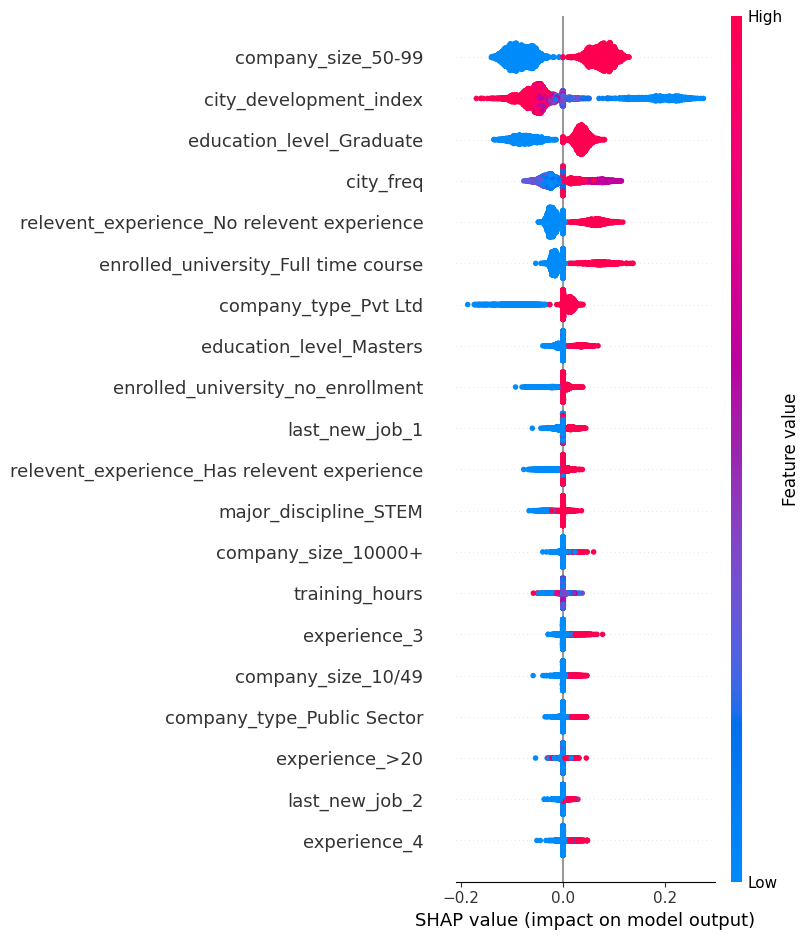

In [53]:
# 解釋特徵對label = 1(Looking for a job change)的影響
shap.summary_plot(shap_values[:,:,1], x_test_array, feature_names=x_test.columns)

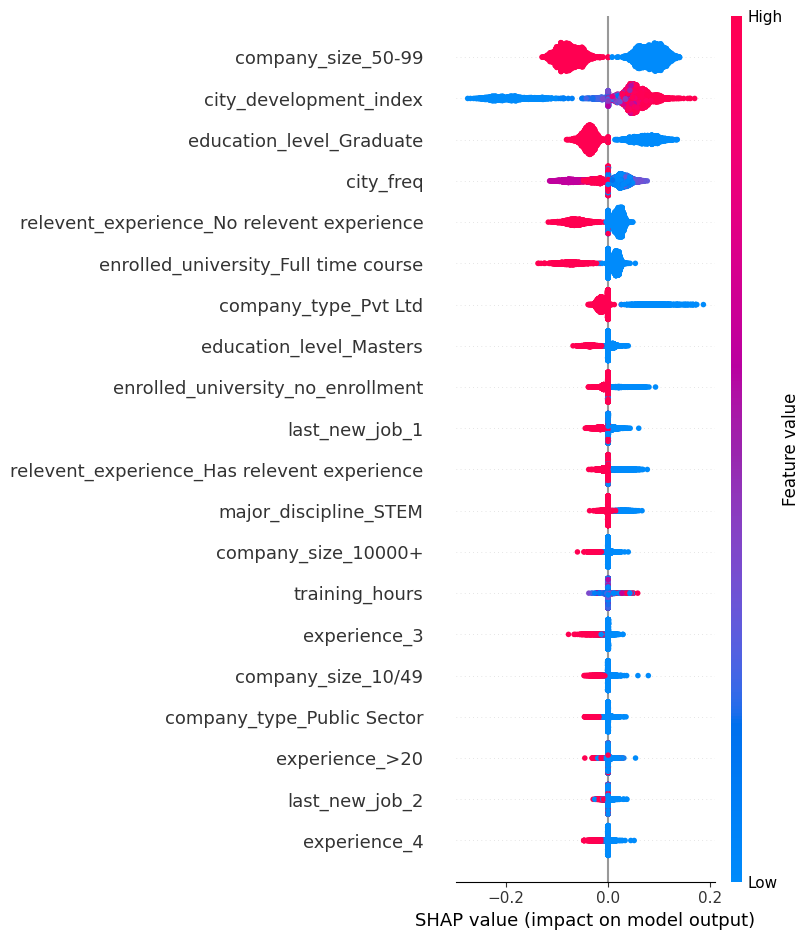

In [54]:
# 解釋特徵對label = 0 (Not looking for job chang)的影響
shap.summary_plot(shap_values[:,:,0], x_test_array, feature_names=x_test.columns)

## TODO: 說明一下你的發現吧
1. 哪些特徵對預測結果影響大?
2. 那些特徵如何影響結果? (EX.某特徵越大，該培訓者越可能找其他工作)
3. 你如何理解這些發現?

有其他見解也可以寫下來~(不強制)